In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from bcb import sgs
from sklearn.linear_model import LinearRegression
import math
from sktime.forecasting.tbats import TBATS

In [8]:
def get_indicators_selic(start_date):
    dados = {'cdi':4391}
    try:
        dataframe = sgs.get(dados,start = start_date)
    except:
        raise TimeoutError('Erro de conexão com o Banco Central')
    dataframe = dataframe.resample('m').mean()
    return dataframe.iloc[:-1]

In [14]:
df = get_indicators_selic('2000-01-01')

<AxesSubplot:xlabel='Date'>

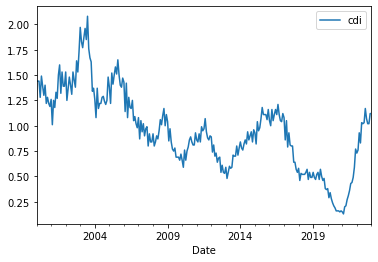

In [10]:
df.plot()

<AxesSubplot:xlabel='Date'>

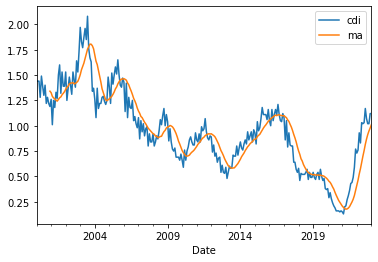

In [13]:
df2 = df.copy()
df2['ma'] = df2['cdi'].rolling(12).mean()
df2.plot()

In [24]:
def linear(x,a,b):
    return (x * a) + b

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def weight(points,expo):
    def ajust(i):
        return sigmoid(i/points) ** expo
    return ajust

def simple_model_predict(serie,projection_points):
    ma = serie.rolling(6).mean().dropna()
    values = ma.values
    last_dif = values[-1] - values[-2]
    line = LinearRegression().fit(np.arange(len(values)).reshape(-1,1),values).predict(np.arange(len(values),len(values) + projection_points).reshape(-1,1)) - values[-1]
    line_derivada = np.cumsum(np.array([last_dif] * projection_points))
    ajuster = weight(10,10)
    final = [(line_derivada[i] * (1 - ajuster(i))) + (line[i] * ajuster(i)) for i in range(projection_points)]
    prediction = final + values[-1]
    micro_diferenca = serie.values[-1] - prediction[0]
    prediction_final = np.array([prediction[i] + (micro_diferenca * (1 - (i / (len(prediction) - 1)))) for i in range(len(prediction))])
    return prediction_final

def predict_selic(df,lags):
    # Treinando o modelo de SELIC
    results = {}
    for anos in lags:
        y_train = df.iloc[:-12 * anos]['cdi']
        prediction = simple_model_predict(y_train,12 * anos)
        pred_df = df.copy()
        pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
        results[anos] = pred_df
    return results

In [25]:
lags = [1,2,3,4,5,6,7]
selic = predict_selic(df,lags)

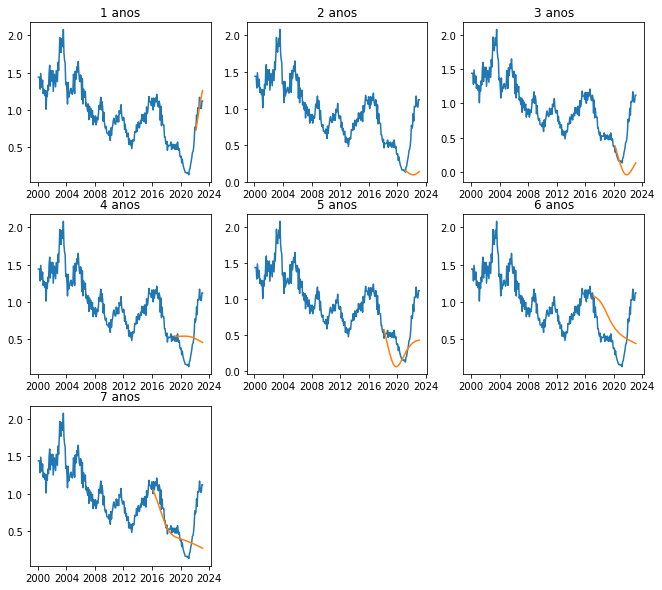

In [26]:
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in lags:
    plt.subplot(3,3,i)
    _ = plt.plot(selic[i].index,selic[i]['cdi'])
    _ = plt.plot(selic[i].index,selic[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

In [61]:
for i in lags:
    selic[i]['res'] = selic[i]['prediction'] - selic[i]['selic']

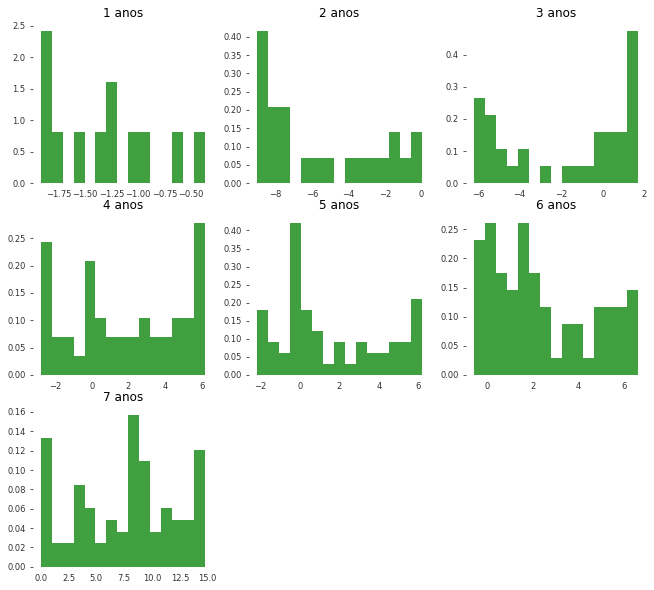

In [63]:
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in lags:
    plt.subplot(3,3,i)
    n, bins, patches = plt.hist(selic[i]['res'], 15, density=True, facecolor='g', alpha=0.75)
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()